# Network of sensors - Feature Selection

## Use case specifications

### Goal

The final objective is to determine the concentration of a pollutant for a given station at a given timestamp (date and time). 11 pollution stations have been selected in Montreal, as well as 1 weather station.

### Inputs available

For this, the available inputs are:
- the GPS positions of the different stations (with meteorological and pollution sensors)
- sensor inputs for each station, with their timestamp ([Meteo data source](https://climat.meteo.gc.ca) and [Pollution data source](https://donnees.montreal.ca/ville-de-montreal/rsqa-polluants-gazeux))
- map data of the city

### Feature selection

The `feature selection` part is essential to avoid an excess of data used by the Machine Learning model which could reduce the quality of prediction.

It is important to note that we work with spatio-temporal type data.

The feature selection will be split into 2 layers: `metadata` and `data`.

### Metadata

Metadata gives the overall context of the data. They allow to perform a pre-processing on them if necessary before making the feature selection.

The question is to know which metadata are necessary and especially how to exploit them. Here is a non-exhaustive list of metadata that may be needed as inputs to perform feature selection correctly.

- GPS positions of the sensors
    - Calculation of distances between sensors: *How to include it later in the feature selection data or model?*
- Seasonality
    - Use of feature selection models taking into account the seasonality aspect
    - Data preprocessing: `new_value[t] = value[t] - value[t - 1 * seasonality]`
- Cartography
    - Topology
        - Influence on distance calculation
    - City infrastructure (housing, factories, streets, etc.)
        - Calculation of `weight` of the sensors
        - Influence on distance calculation
- Meteorology
    - Data pre-processing: *Should the weather sensors be considered as metadata used to transform the data or just be included in the data?* In the case of the use of pollution, one can imagine that physics makes it There is a time lag between two sensors also related to wind speed and direction.

In [2]:
%%capture --no-stdout

# Importation of librairies

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from libs.utils_pollution import *
from libs.utils_meteorological import *
from libs.utils_data import *
from libs.utils_spatial import *
from libs.utils_stat import *

from libs.sts_featureselection import *

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering



from statsmodels.tsa.api import VAR

import warnings
warnings.filterwarnings("ignore")

## Data preparation

In [3]:
# Export all useful constants

# csv_stations_references = "https://data.montreal.ca/dataset/ae01f7f3-4d69-404a-9be1-74abfdc96571/resource/29db5545-89a4-4e4a-9e95-05aa6dc2fd80/download/liste-des-stations-rsqa.csv"
csv_stations_references = "./data/liste-des-stations-rsqa.csv"

# csv_all_pollutants = "https://data.montreal.ca/dataset/a2eea289-f9b1-4e51-a6fc-3299aa8f2ba7/resource/811e76d0-90cb-4703-bd6f-bd0faff81f4a/download/rsqa-multi-polluants2020.csv"
csv_all_pollutants = "./data/rsqa-multi-polluants2020.csv"

meteorological_stations_ids = [51157, 49608, 30165, 48374]
csv_meteo_api = "https://climat.meteo.gc.ca/climate_data/bulk_data_f.html?format=csv&stationID={STATIONID}&Year={YEAR}&Month={MONTH}&Day={DAY}&time=UTC&timeframe=1&submit=T%C3%A9l%C3%A9charger%20des%20donn%C3%A9es"

### Visualization of pollution stations

In [4]:
stations_references = pd.read_csv(csv_stations_references)

In [5]:
#visualise_stations(stations_references[stations_references.statut == 'ouvert'])

### Import and clean pollution data

#### Import

In [6]:
pollution_data = pd.read_csv(csv_all_pollutants)
pollution_data.head(2)

,numero_station,date_heure,co,no,no2,pm2_5,pst,pm10,o3,so2,bc1_370nm,bc6_880nm,Benzene,Toluene,Ethylbenzene,M P-Xylene,O-Xylene
0,3,01-01-2020 01:00,N/M,0.121867,8.667018,8.746077,N/M,N/M,15.65643,0,N/M,N/M,5.743625,2.754026,0.355111,6.189929,0.569096
1,3,01-01-2020 02:00,N/M,0.070021,5.937763,5.5934,N/M,N/M,16.69138,0,N/M,N/M,1.40336,1.692388,0.479124,17.34458,0.638791


#### Clean

In [7]:
# We transform the datafame to have a column by sensor by station instead of a column for the station ID and the other for the sensor's name
pollution_data = transform_all_pollutants_data(pollution_data)

# We transform unknow key values / non numerical values to na
pollution_data = convert_unknown_values_to_na(pollution_data)

# We remove columns containing only na values
pollution_data = remove_empty_columns(pollution_data)

#### Pollution dataframe

In [8]:
pollution_data.head(2)

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,no2_station_99,pm2_5_station_99,o3_station_99,so2_station_99,no_station_103,no2_station_103,pm2_5_station_103,pst_station_103,pm10_station_103,o3_station_103
date_heure,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,3.248914,2.837178,20.53666,0.0,0.0,4.582468,4.249444,5.496387,5.493054,18.90542
2020-01-01 02:00:00,0.070021,5.937763,5.593400,16.69138,0.0,1.403360,1.692388,0.479124,17.344580,0.638791,...,3.324254,3.145111,20.52980,0.0,0.0,4.323431,5.813416,8.411389,8.065554,18.67736


In [9]:
# Show all features available for the pollution dataframe
', '.join(pollution_data.columns)

'no_station_3, no2_station_3, pm2_5_station_3, o3_station_3, so2_station_3, Benzene_station_3, Toluene_station_3, Ethylbenzene_station_3, M P-Xylene_station_3, O-Xylene_station_3, no_station_6, no2_station_6, pm2_5_station_6, o3_station_6, so2_station_6, co_station_17, no_station_17, no2_station_17, pm2_5_station_17, o3_station_17, co_station_28, no_station_28, no2_station_28, pm2_5_station_28, pst_station_28, pm10_station_28, o3_station_28, co_station_31, no_station_31, no2_station_31, pm2_5_station_31, o3_station_31, so2_station_31, pm2_5_station_50, pst_station_50, pm10_station_50, co_station_55, no_station_55, no2_station_55, pm2_5_station_55, o3_station_55, bc1_370nm_station_55, bc6_880nm_station_55, co_station_66, no_station_66, no2_station_66, pm2_5_station_66, o3_station_66, no_station_80, no2_station_80, pm2_5_station_80, o3_station_80, so2_station_80, no_station_99, no2_station_99, pm2_5_station_99, o3_station_99, so2_station_99, no_station_103, no2_station_103, pm2_5_station

### Import and clean meteorological data

#### Import

In [10]:
use_local_file = True

if(use_local_file==True): # loading the local csv file
    meteorological_data = pd.read_csv('./data/meteorological_data.csv')
    meteorological_data['Date/Heure (UTC)'] = pd.to_datetime(meteorological_data['Date/Heure (UTC)'], format='%Y-%m-%d %H:%M')
    meteorological_data = meteorological_data.set_index('Date/Heure (UTC)')

else: # loading meteorological data from the api
    # Save datetime indexes as a variable
    datetime_indexes = pollution_data.index.values
    
    # Load the meteorological for the datetime indexes
    meteorological_data = load_meteorological_data(datetime_indexes, csv_meteo_api, meteorological_stations_ids)

meteorological_data.head(2)

,Longitude (x),Latitude (y),Nom de la Station,ID climatologique,Année,Mois,Jour,Heure (UTC),Temp (°C),Temp Indicateur,...,Vit. du vent Indicateur,Visibilité (km),Visibilité Indicateur,Pression à la station (kPa),Pression à la station Indicateur,Hmdx,Hmdx Indicateur,Refroid. éolien,Refroid. éolien Indicateur,Temps
Date/Heure (UTC),,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,00:00,"0,5",NaN,...,NaN,"2,4",NaN,"99,44",NaN,NaN,NaN,NaN,NaN,Neige
2020-01-01 01:00:00,"-73,74","45,47",MONTREAL INTL A,7025251,2020,1,1,01:00,"0,6",NaN,...,NaN,"4,0",NaN,"99,41",NaN,NaN,NaN,NaN,NaN,Neige


#### Clean

In [11]:

# We remove the columns containing only na values
meteorological_data = remove_empty_columns(meteorological_data)

# We remove the columns that we dont want to use
meteorological_data = remove_unused_columns(meteorological_data)

# We convert the columns to the float type
meteorological_data = convert_columns_to_float_type(meteorological_data)

#### Meteorological dataframe

In [12]:
meteorological_data.head(2)

,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Hmdx,Refroid. éolien
Date/Heure (UTC),,,,,,,,,
2020-01-01 00:00:00,0.5,-0.3,94.0,9.0,5.0,2.4,99.44,NaN,NaN
2020-01-01 01:00:00,0.6,0.0,96.0,16.0,13.0,4.0,99.41,NaN,NaN


In [13]:
# Show all features available for the meteorological dataframe
', '.join(meteorological_data.columns)

'Temp (°C), Point de rosée (°C), Hum. rel (%), Dir. du vent (10s deg), Vit. du vent (km/h), Visibilité (km), Pression à la station (kPa), Hmdx, Refroid. éolien'

### Concatenation of pollution and meteorological dataframes

In [14]:
data = pd.concat([pollution_data, meteorological_data], axis=1, join='outer')
data.head(2)

,no_station_3,no2_station_3,pm2_5_station_3,o3_station_3,so2_station_3,Benzene_station_3,Toluene_station_3,Ethylbenzene_station_3,M P-Xylene_station_3,O-Xylene_station_3,...,o3_station_103,Temp (°C),Point de rosée (°C),Hum. rel (%),Dir. du vent (10s deg),Vit. du vent (km/h),Visibilité (km),Pression à la station (kPa),Hmdx,Refroid. éolien
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5,-0.3,94.0,9.0,5.0,2.4,99.44,NaN,NaN
2020-01-01 01:00:00,0.121867,8.667018,8.746077,15.65643,0.0,5.743625,2.754026,0.355111,6.189929,0.569096,...,18.90542,0.6,0.0,96.0,16.0,13.0,4.0,99.41,NaN,NaN


### Inspect and manage missing values

#### Inspect

>>> Missing value visualization:


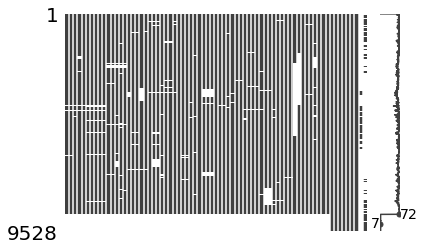

In [15]:
inspect_data(df = data)

We plot sample of our dataframe to see the different features (pollution and meteorological)

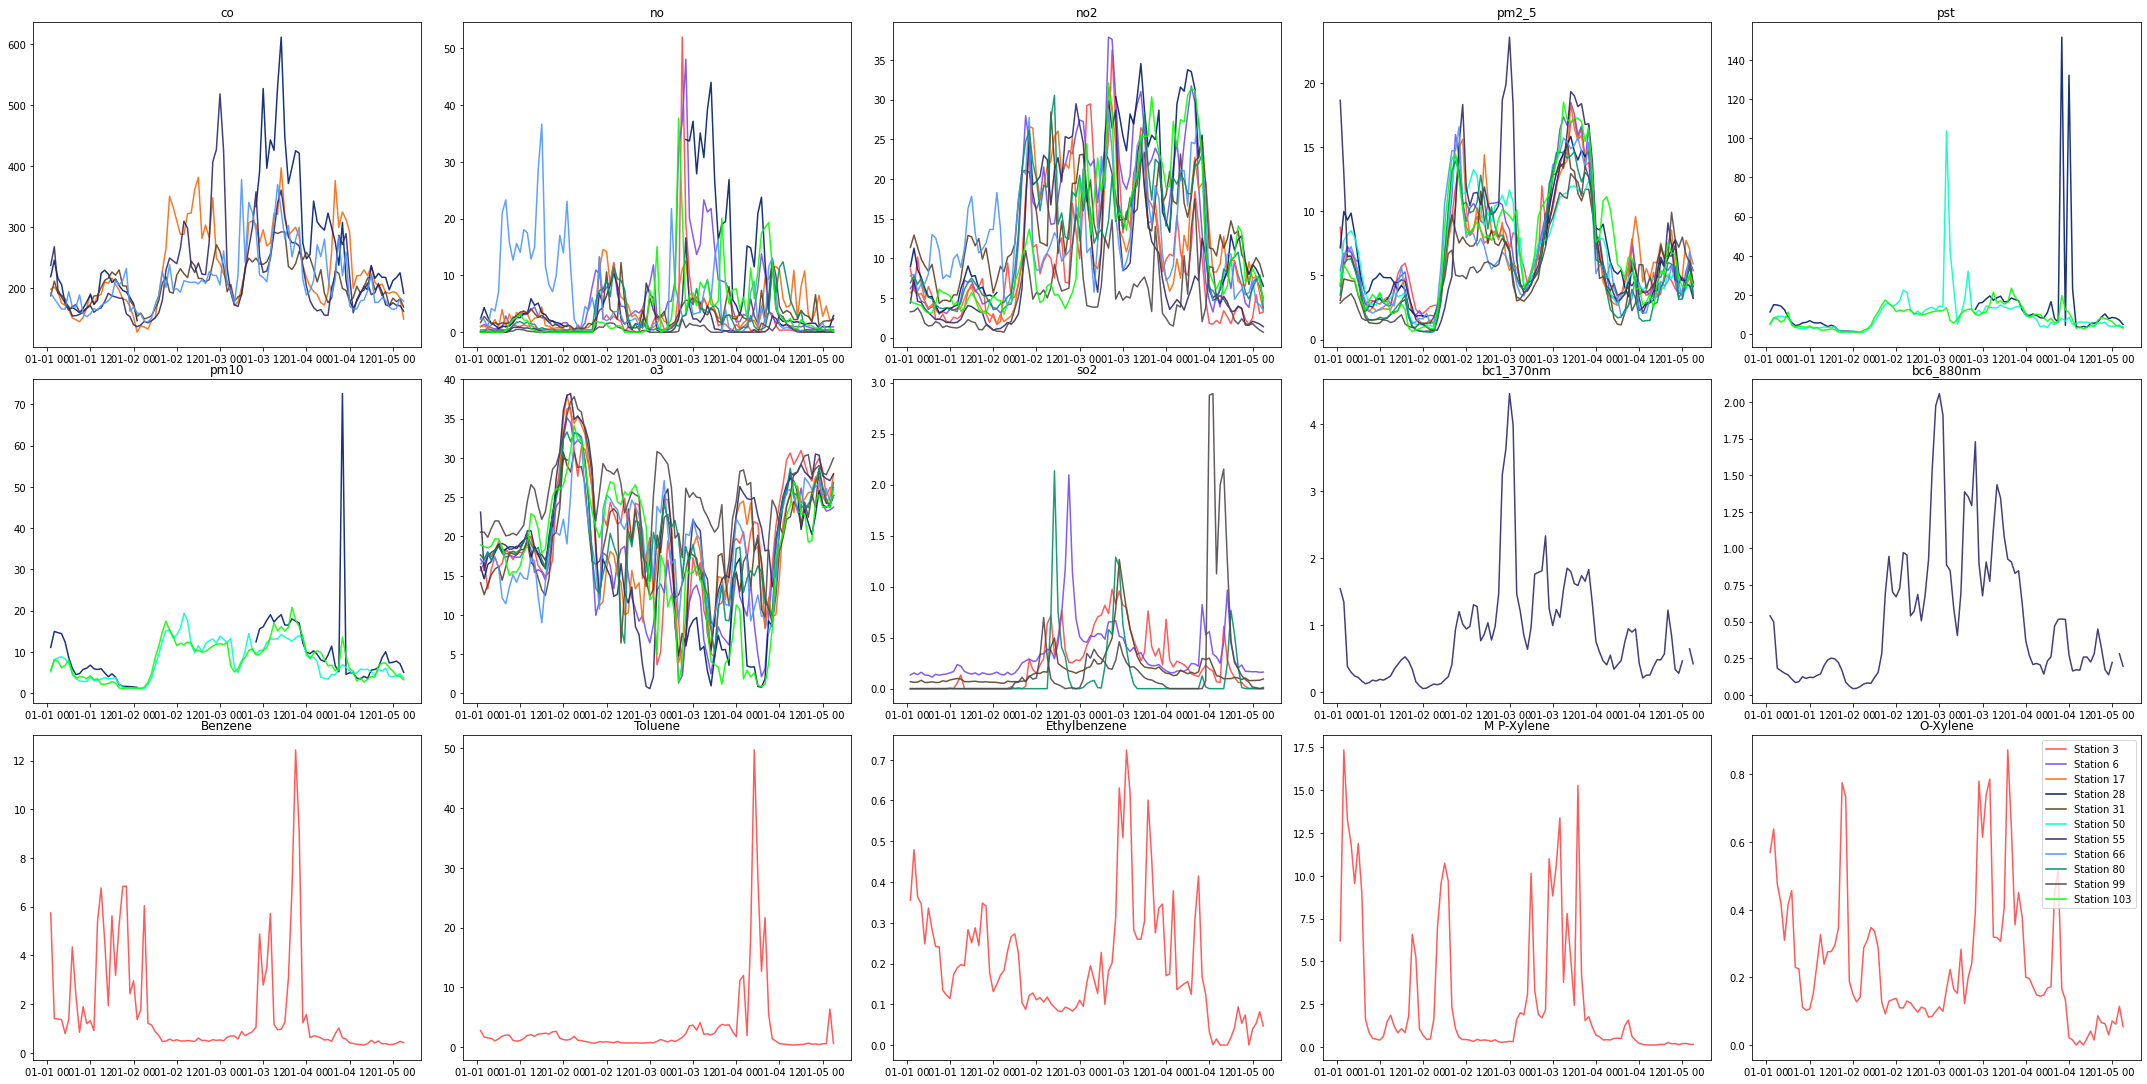

In [16]:
plot_pollution_data(data[:100])

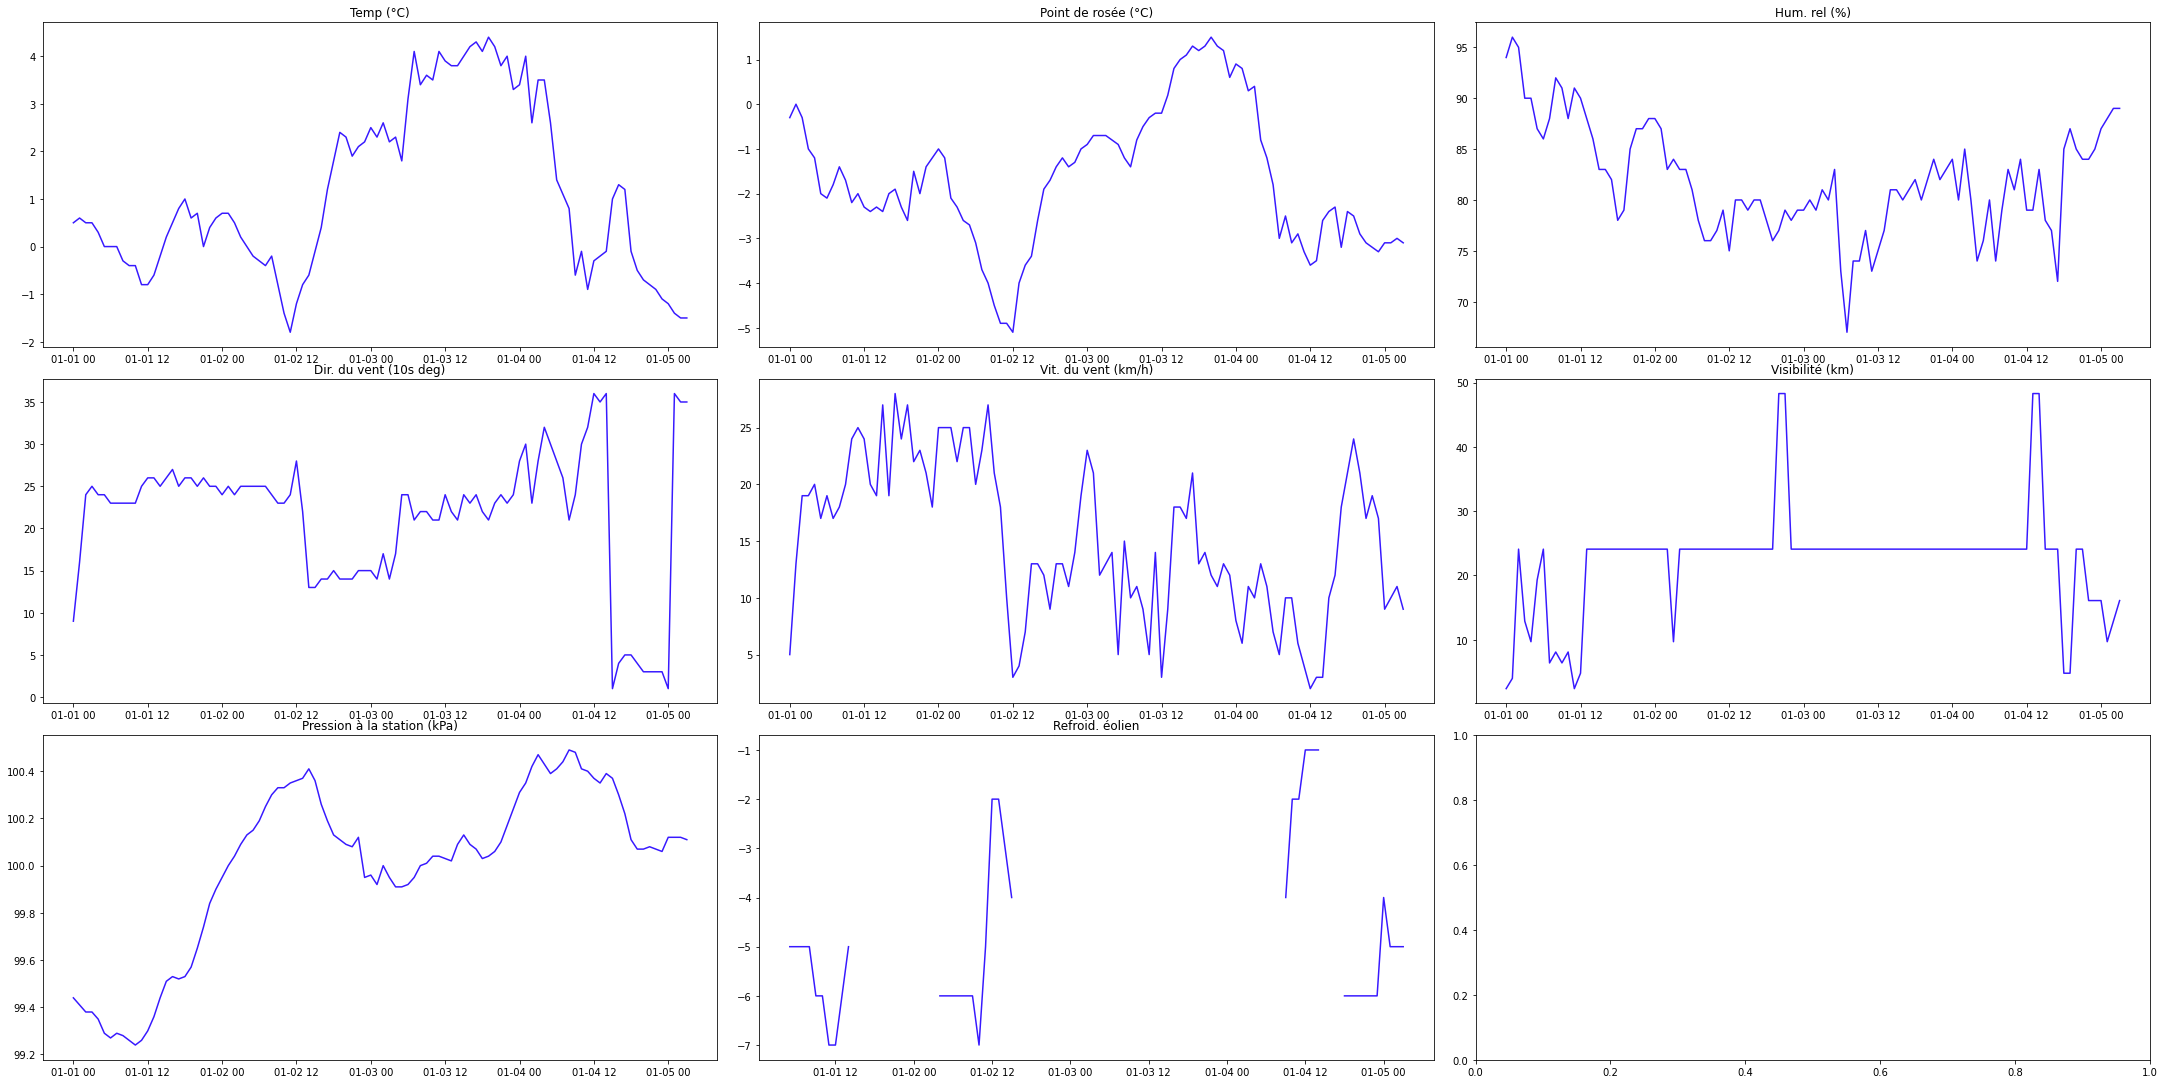

In [17]:
plot_meteorological_data(data[:100])

#### Manage

We choose a classic forward then backward fill for missing values. Other methods can be used to fill data such as `interpolate` (linear or exponential), `mean`, `median`, `mode`.

>>> Missing value visualization:


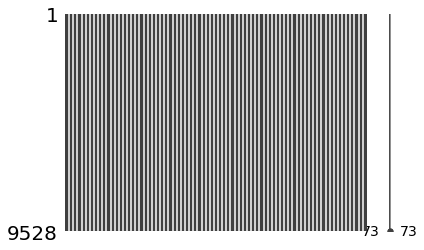

In [18]:
data = data.fillna(method='ffill')
data = data.fillna(method='bfill')
inspect_data(df = data)

In [19]:
# As the RFE algorithm is time-consuming, we remove the most correlated features to reduce the loading time
correlated_features = set()
correlation_matrix = data.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

data_light = data.drop(correlated_features, axis=1)

### Autocorrelation (ACF)

Plotting the **autocorrelation**, meaning the correlation between time series and a lagged version of itself. 

Blue bars on an ACF plot below are the error bands and anything within these bars is not statistically significant. It means that correlation values outside of this area are very likely a correlation and not a statistical fluke. The confidence interval is set to 95% by default.

Notice that for a lag 0, ACF is always 1.

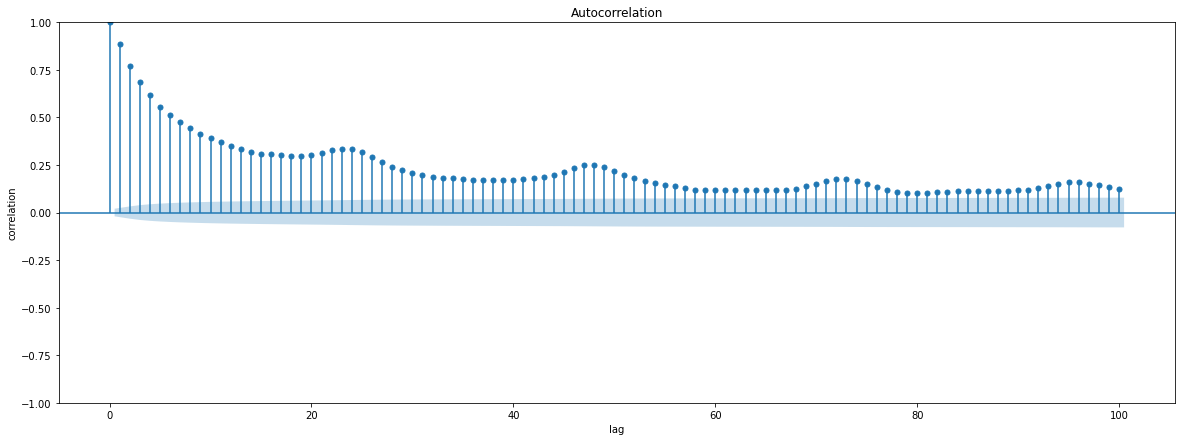

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
plt.rcParams["figure.figsize"] = (20,7)
acf_plot = plot_acf(data['no2_station_3'].values, lags = 100)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

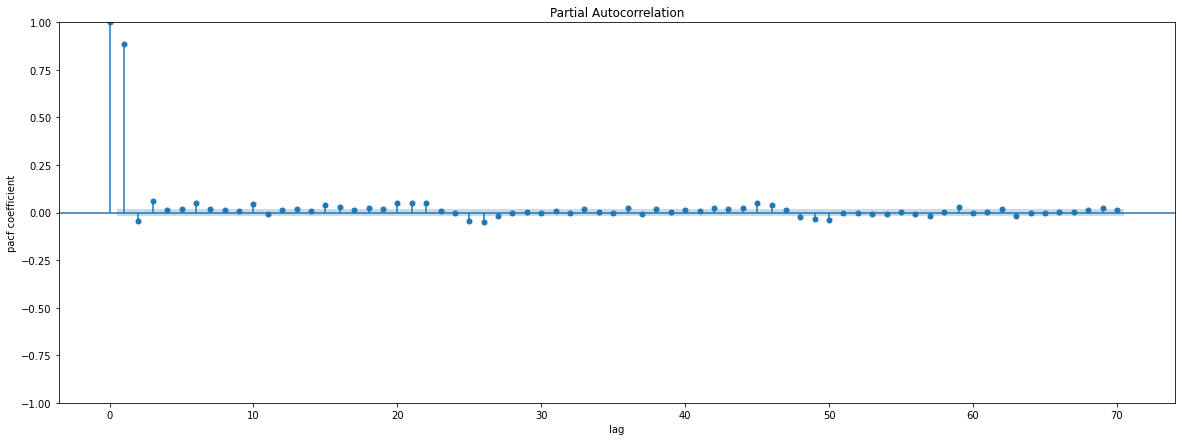

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf

pacf_plot = plot_pacf(data['no2_station_3'].values, lags = 70)
plt.xlabel('lag')
plt.ylabel('pacf coefficient')
plt.show()

***

## Feature Selection

The main goal of this notebook is to explore the various feature selection techniques and compare them in order to retain the best ones. But first, let's define clearly what is the feature selection.


### What is feature selection?

Feature selection is a dimensionnality reduction techniques aiming to choose a small subset of the relevant features from the original features by removing irrelevant, redundant, or noisy features. Feature selection usually can lead to better learning performance, higher learning accuracy, lower computational cost, and better model interpretability.

Feature selection occurs as a data preprocessing step in the ML pipeline. It has been proven to be effective and efficient in preparing high-dimensional data for machine learning and pattern recognition problems.

![Image of Danny Butvinik](https://miro.medium.com/max/888/1*vJdhKDHgLLV7el7Vm4PuEQ.jpeg)


### Which techniques?

Feature selection techniques can be roughly summarized in 3 categories: Filter, wrapper and embedded methods.

*   ***Filter methods***: features are selected based on statistical measures. It is independent of the learning algorithm and requires less computational time. Among existing techniques: chi-2, pearson correlation, missing value ratio..
*   ***Wrapper methods***: in wrapper methods a predictive model is used to evaluate a combination of features and assign model performance scores. The performance of the Wrapper method depends on the classifier. The best subset of features is selected based on the results of the classifier. Wrapper methods are computationally more expensive than filter methods, due to the repeated learning steps and cross-validation. However, these methods are more accurate than the filter method. Some of the examples are Recursive feature elimination, Sequential feature selection algorithms, and Genetic algorithms.
*   ***Embedded methods***: in embedded methods, there are ensemble learning and hybrid learning methods for feature selection. Since it has a collective decision, its performance is better than the other two models. Random forest is one such example. It is computationally less intensive than wrapper methods. However, this method has a drawback specific to a learning model.
In embedded techniques, the feature selection algorithm is integrated as part of the learning algorithm. The most typical embedded technique is the decision tree algorithm. Decision tree algorithms select a feature in each recursive step of the tree growth process and divide the sample set into smaller subset

![Image of Danny Butvinik](https://miro.medium.com/max/1400/1*9h2qPmOJonbCdthfeVkuyg.jpeg)



#### To test the outputs of certain feature selection techniques, we will define two different targets representing the pollutants measured by the sensors. By default, we will take PM 2.5 and station NO 3.

In [15]:
# We define our targets, here by default PM 2.5 and NO of station 3
target_1 = 'pm2_5_station_3'
target_2 = 'no_station_3'

# We define the number of features to select
n_features = 15

In [111]:
#Working on a small subset of the data as the algorithms are time-consuming
#We consider here only 3months
df = data_light["2020"].asfreq("d")

X_1 = df.drop(target_1, axis=1)
y_1 = df[target_1]

X_2 = df.drop(target_2, axis=1)
y_2 = df[target_2]

### **Pearson Correlation (Filter method)**

A statistic that measures the linear correlation between two variables, both of which are continuous. It varies from -1 to +1, where
+1 corresponds to a positive linear correlation, 0 to no linear correlation, and -1 to a negative linear correlation.

In [26]:
# Calcul du coefficient de pearson
target_correlation_1 = df.corr()[[target_1]]
target_correlation_2 = df.corr()[[target_2]]

In [27]:
features_1 = list(abs(target_correlation_1).sort_values(by=target_1, ascending=False)[:n_features].index)
features_2 = list(abs(target_correlation_2).sort_values(by=target_2, ascending=False)[:n_features].index)

Thanks to this method we can decide to keep only the features most correlated with our target.

<AxesSubplot:>

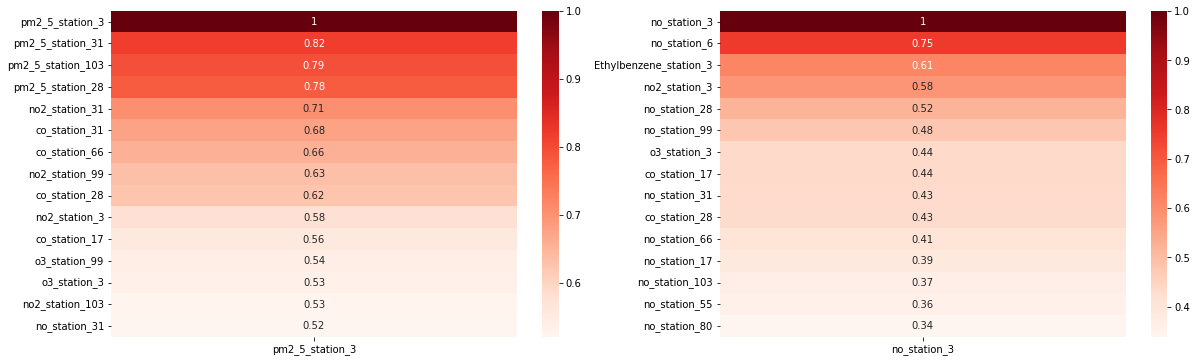

<Figure size 1728x1728 with 0 Axes>

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
fig = plt.figure(figsize=(24,24))
fig.suptitle('Most correlated features with targets PM2.5 and NO')

# We visualize on a heatmap the correlations with the target

# We visualize it on the features most correlated with the target
sns.heatmap(abs(target_correlation_1.loc[features_1]), annot=True, cmap=plt.cm.Reds, ax=ax1)
sns.heatmap(abs(target_correlation_2.loc[features_2]), annot=True, cmap=plt.cm.Reds, ax=ax2)

Among the features most correlated with our target, we should keep only those that are not strongly correlated with each other (otherwise we are on a redundancy of information). This step should be done before any other feature selection technique.

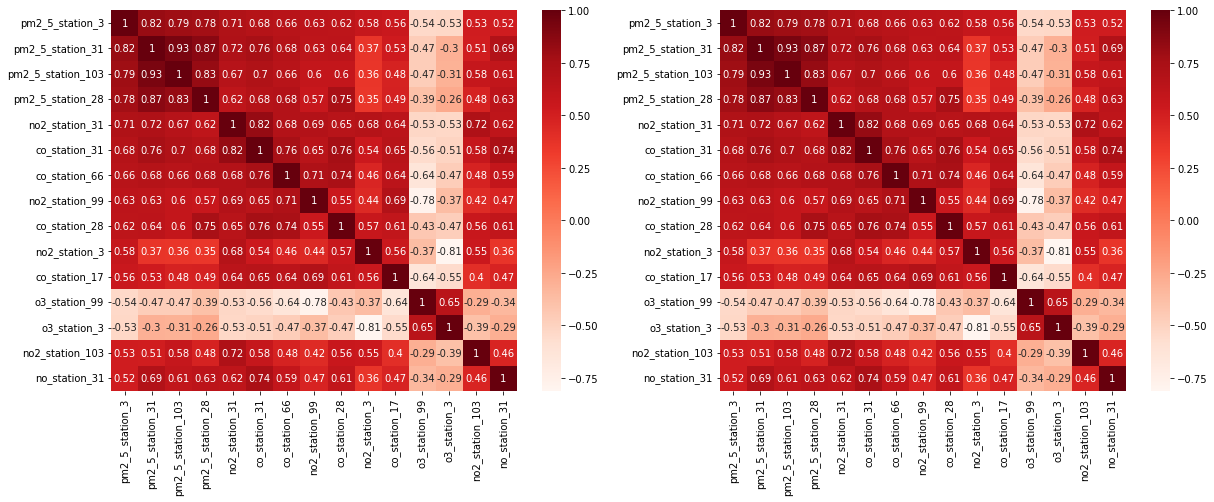

<Figure size 1728x1728 with 0 Axes>

In [29]:
# We look at correlation between chosen features
feature_correlation_1 = df.corr().loc[features_1][features_1]
feature_correlation_2 = df.corr().loc[features_2][features_2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig = plt.figure(figsize=(24,24))
fig.suptitle('Correlation between chosen features')

sns.heatmap(feature_correlation_1, annot=True, cmap=plt.cm.Reds, ax=ax1)
sns.heatmap(feature_correlation_1, annot=True, cmap=plt.cm.Reds, ax=ax2)

plt.show()

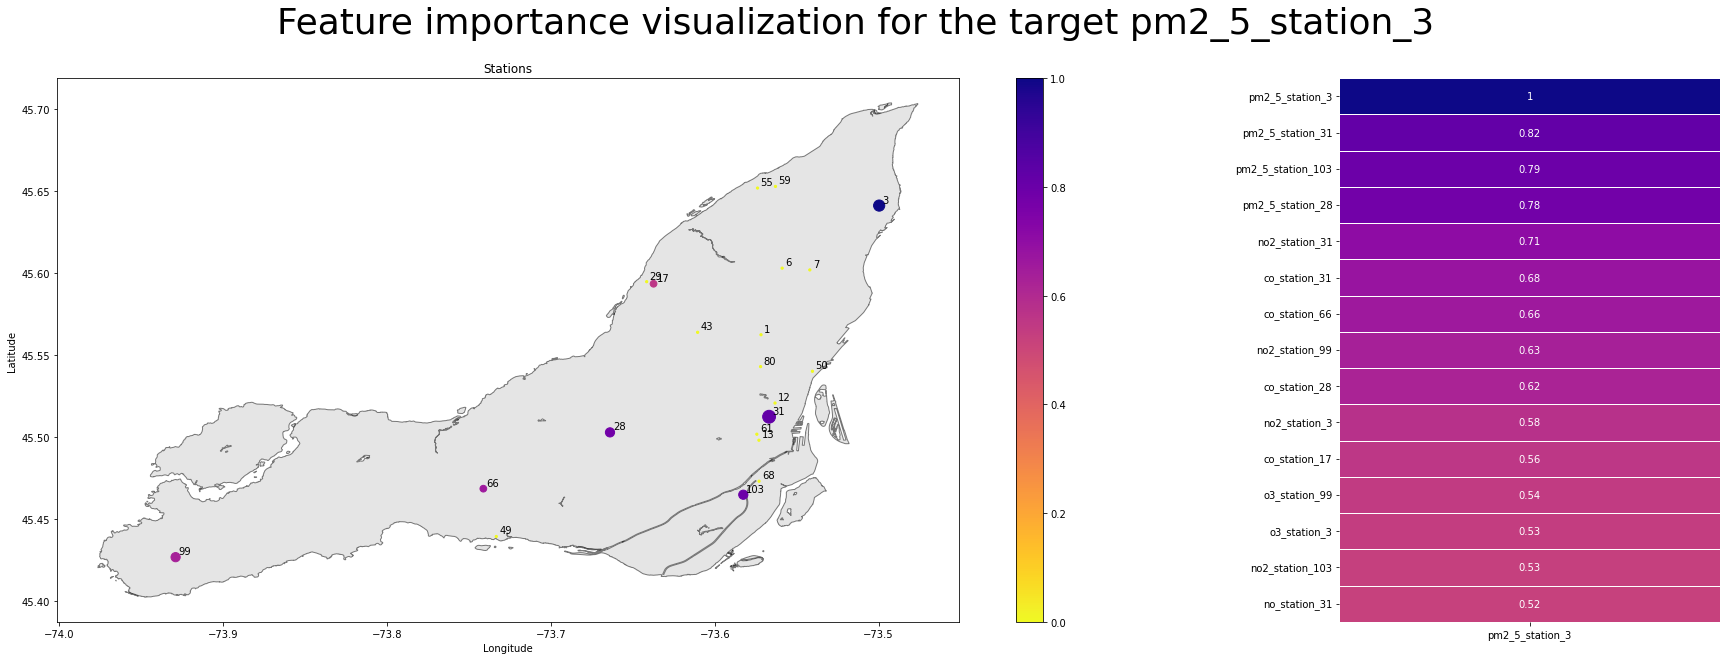

In [31]:
display_feature_importance(abs(target_correlation_1.loc[features_1]), target_1, stations_references, borough_geojson_file)

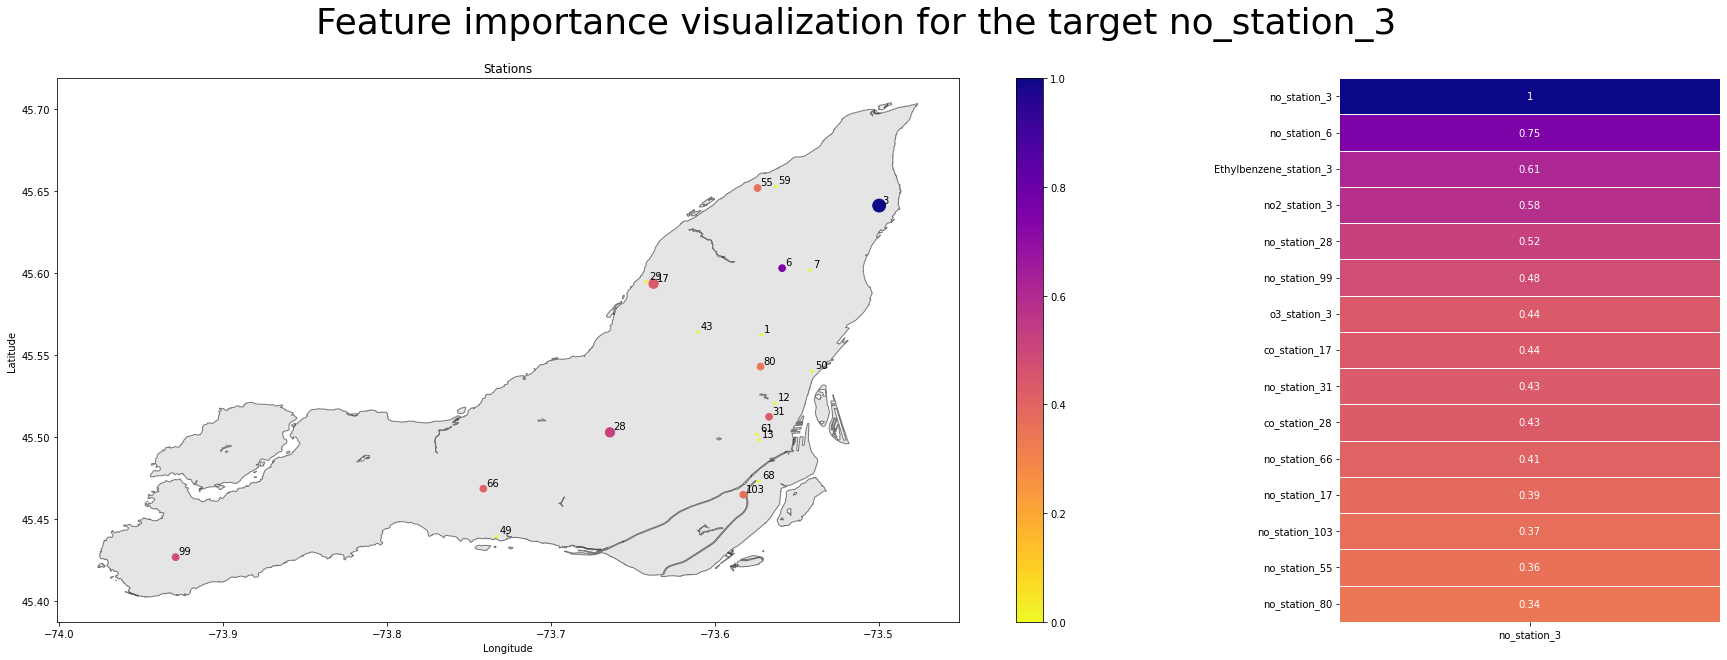

In [30]:
display_feature_importance(abs(target_correlation_2.loc[features_2]), target_2, stations_references, borough_geojson_file)

### **Recursive Feature Elimination (Wrapper method)**

RFE searches for a subset of features starting with all features in the training dataset and dropping features until the desired number remains.

To do this, RFE uses an ML model that is adjusted. Features are listed in order of importance. The less important features are eliminated and the model is readjusted. This process is repeated until a given number of features remain.

Feature selection techniques can be time-consuming. As we have a lot of features (more than 70), we should try removing as much as possible irrelevant features. We can use the Pearson Correlation to remove highly correlated features as they convey the same information, as well as poorly correlated feature with our target.

In [32]:
#We first remove target poorly correlated features and then highly correlated features

#We remove target poorly correlated features
not_corr_1 = abs(target_correlation_1).sort_values(by=target_1)
not_correlated_features_1 = list(not_corr_1[not_corr_1[target_1] < 0.1].index)
not_corr_2 = abs(target_correlation_2).sort_values(by=target_2)
not_correlated_features_2 = list(not_corr_2[not_corr_2[target_2] < 0.1].index)

correlated_features = set()
correlation_matrix = df.corr()

#We remove highly correlated features
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

drop_features_1, drop_features_2 = correlated_features, correlated_features

drop_features_1.update(not_correlated_features_1)
drop_features_2.update(not_correlated_features_2)

X_1 = X_1.drop(drop_features_1, axis=1)
X_2 = X_2.drop(drop_features_2, axis=1)

Here we use the Random Forests model, a classification algorithm composed of many decision trees, as the basis of our feature selection technique.

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV

rfc_1 = RandomForestRegressor(random_state=101)
rfc_2 = RandomForestRegressor(random_state=102)

In [ ]:
rfe_1 = RFECV(estimator=rfc_1, step=1, verbose=True)
rfe_1.fit(X_1, y_1)

In [ ]:
rfe_2 = RFECV(estimator=rfc_2, step=1, verbose=True)
rfe_2.fit(X_2, y_2)

RFE tell us what is the optimal number of features in the model used to achieve the best regression/classification score (regression in our case)

In [106]:
print('Optimal number of features for target_1: {}'.format(rfe_1.n_features_))
print('Optimal number of features for target_2: {}'.format(rfe_2.n_features_))

Optimal number of features for target_1: 15
Optimal number of features for target_2: 13


In [118]:
optimal_features_ranking_1 = rfe_1.ranking_
ind_1 = np.where(optimal_features_ranking_1 == 1)[0]
print("Optimal features: ", list(X_1.iloc[:,ind_1].columns))

optimal_features_ranking_2 = rfe_2.ranking_
ind_2 = np.where(optimal_features_ranking_2 == 1)[0]
print("Optimal features: ", list(X_2.iloc[:,ind_2].columns))

Optimal features:  ['pm2_5_station_3', 'pm2_5_station_6', 'pm2_5_station_17', 'pm2_5_station_28', 'co_station_31', 'pm2_5_station_31', 'pm2_5_station_50', 'co_station_66', 'pm2_5_station_66', 'pm2_5_station_80', 'pm2_5_station_99', 'no_station_103', 'no2_station_103', 'pm10_station_103']
Optimal features:  ['no_station_3', 'pm2_5_station_3', 'o3_station_3', 'so2_station_3', 'Benzene_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3', 'M P-Xylene_station_3', 'no2_station_6', 'so2_station_6', 'no2_station_17', 'co_station_28', 'no2_station_28', 'o3_station_28', 'no_station_31', 'no2_station_31', 'co_station_55', 'no2_station_55', 'bc6_880nm_station_55', 'no2_station_80', 'no2_station_99', 'so2_station_99', 'no2_station_103', 'pm10_station_103']


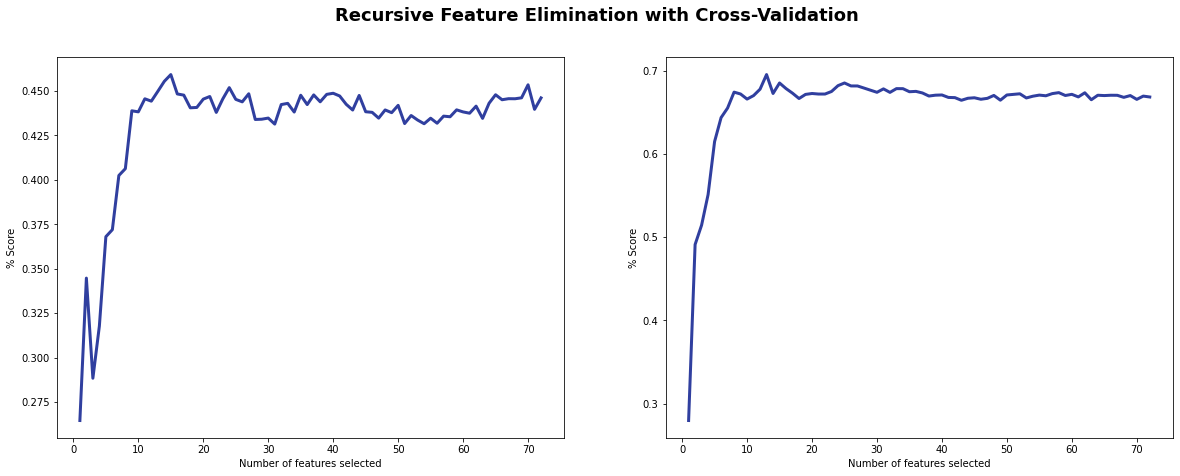

In [109]:
# Display of the score according to the number of features taken into account by the model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold')

ax1.set(xlabel='Number of features selected', ylabel='% Score')
ax2.set(xlabel='Number of features selected', ylabel='% Score')

ax1.plot(range(1, len(rfe_1.grid_scores_) + 1), rfe_1.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)
ax2.plot(range(1, len(rfe_2.grid_scores_) + 1), rfe_2.cv_results_['mean_test_score'], color='#303F9F', linewidth=3)

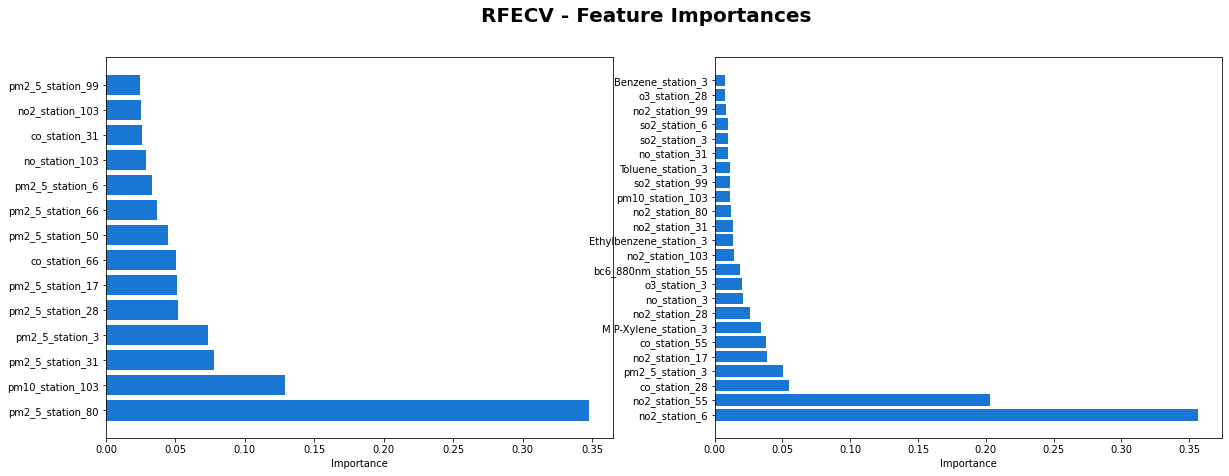

In [119]:
# Display of the importance of all features to predict the target

#Target_1
dset_1 = pd.DataFrame()
dset_1['attr'] = X_1.iloc[:,ind_1].columns
dset_1['importance'] = rfe_1.estimator_.feature_importances_

dset_1 = dset_1.sort_values(by='importance', ascending=False)

#Target_2
dset_2 = pd.DataFrame()
dset_2['attr'] = X_2.iloc[:,ind_2].columns
dset_2['importance'] = rfe_2.estimator_.feature_importances_

dset_2 = dset_2.sort_values(by='importance', ascending=False)

#Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('RFECV - Feature Importances', fontsize=20, fontweight='bold')

ax1.set(xlabel='Importance')
ax2.set(xlabel='Importance')

ax1.barh(y=dset_1['attr'], width=dset_1['importance'], color='#1976D2')
ax2.barh(y=dset_2['attr'], width=dset_2['importance'], color='#1976D2')

plt.show()

### **Boruta (Wrapper method)**

Unlike the RFE technique where features competed with each other for a place in the final subset, in Boruta features competed with a randomized version of themselves (shadow features). A feature is selected only if it performs better than the best performing random feature.

![Image of Manish Pathak](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1520429681/boruta_algo_ft1i8z.png)

The procedure is repeated N times (number of trials) and the final step is to compare the number of times a feature was better than its shadow features using a binomial distribution. When it comes to blue zone features, Boruta's algorithm is undecided,
while features in the green and red zone must be selected and discarded, respectively.

![Image of Samuele Mazzanti](https://miro.medium.com/max/1400/1*yqAUlMtPUiFyr8gYLFagTA.png)



In [ ]:
from boruta import BorutaPy

# The model here is the same as for the RFE, i.e a Random Forest model
estimator = RandomForestRegressor()

boruta_1 = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100, verbose=True)
boruta_1.fit(np.array(X_1), np.array(y_1))

boruta_2 = BorutaPy(estimator = estimator, n_estimators = 'auto', max_iter = 100, verbose=True)
boruta_2.fit(np.array(X_2), np.array(y_2))

We can display the features considered important, non-important and those not categorized.

In [137]:
#For target_1

#Features importantes
important = list(X_1.columns[boruta_1.support_])
print(f"Features confirmed as important: {important}")

# Features non catégorisées
tentative = list(X_1.columns[boruta_1.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

# Features non importantes
unimportant = list(X_1.columns[~(boruta_1.support_ | boruta_1.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['pm2_5_station_3', 'pm2_5_station_6', 'pm2_5_station_17', 'pm2_5_station_28', 'co_station_31', 'pm2_5_station_31', 'pm2_5_station_50', 'co_station_66', 'pm2_5_station_66', 'pm2_5_station_80', 'pm2_5_station_99', 'no_station_103', 'no2_station_103', 'pm10_station_103']
Unconfirmed features (tentative): ['no2_station_3', 'co_station_28']
Features confirmed as unimportant: ['no_station_3', 'o3_station_3', 'so2_station_3', 'Benzene_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3', 'M P-Xylene_station_3', 'no_station_6', 'no2_station_6', 'so2_station_6', 'co_station_17', 'no_station_17', 'no2_station_17', 'no_station_28', 'no2_station_28', 'pst_station_28', 'pm10_station_28', 'o3_station_28', 'no_station_31', 'no2_station_31', 'so2_station_31', 'pst_station_50', 'pm10_station_50', 'co_station_55', 'no_station_55', 'no2_station_55', 'pm2_5_station_55', 'bc1_370nm_station_55', 'bc6_880nm_station_55', 'no_station_66', 'no2_station_66', 'no_station_80'

In [138]:
#For target_2

#Features importantes
important = list(X_2.columns[boruta_2.support_])
print(f"Features confirmed as important: {important}")

# Features non catégorisées
tentative = list(X_2.columns[boruta_2.support_weak_])
print(f"Unconfirmed features (tentative): {tentative}")

# Features non importantes
unimportant = list(X_2.columns[~(boruta_2.support_ | boruta_2.support_weak_)])
print(f"Features confirmed as unimportant: {unimportant}")

Features confirmed as important: ['no_station_3', 'pm2_5_station_3', 'o3_station_3', 'Toluene_station_3', 'Ethylbenzene_station_3', 'M P-Xylene_station_3', 'no2_station_6', 'no2_station_17', 'co_station_28', 'no2_station_28', 'no_station_31', 'co_station_55', 'no2_station_55', 'bc6_880nm_station_55', 'so2_station_99', 'no2_station_103', 'pm10_station_103']
Unconfirmed features (tentative): ['no2_station_31']
Features confirmed as unimportant: ['so2_station_3', 'Benzene_station_3', 'no_station_6', 'pm2_5_station_6', 'so2_station_6', 'co_station_17', 'no_station_17', 'pm2_5_station_17', 'no_station_28', 'pm2_5_station_28', 'pst_station_28', 'pm10_station_28', 'o3_station_28', 'co_station_31', 'pm2_5_station_31', 'so2_station_31', 'pm2_5_station_50', 'pst_station_50', 'pm10_station_50', 'no_station_55', 'pm2_5_station_55', 'bc1_370nm_station_55', 'co_station_66', 'no_station_66', 'no2_station_66', 'pm2_5_station_66', 'no_station_80', 'no2_station_80', 'pm2_5_station_80', 'so2_station_80',

### **Boruta SHAP**

Boruta is a robust method for feature selection, but it strongly relies on the calculation of the feature importances, which might be biased or not good enough for the data.
This is where SHAP joins the team. By using SHAP Values as the feature selection method in Boruta, we get the Boruta SHAP Feature Selection Algorithm. With this approach we can get the strong addictive feature explanations existent in SHAP method while having the robustness of Boruta algorithm to ensure only significant variables remain on the set.

#### **SHAP (SHapley Additive exPlanations)** 
SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.
Linear models, for example, can use their coefficients as a metric for the overall importance of each feature, but they are scaled with the scale of the variable itself, which might lead to distortions and misinterpretations. Also, the coefficient cannot account for the local importance of the feature, and how it changes with lower or higher values. The same can be said for feature importances of tree-based models, and this is why SHAP is useful for interpretability of models.

In [ ]:
from BorutaShap import BorutaShap

# Creates a BorutaShap selector for regression
boruta_shap_1 = BorutaShap(importance_measure = 'shap', classification = False)
boruta_shap_2 = BorutaShap(importance_measure = 'shap', classification = False)

# Fits the selector
boruta_shap_1.fit(X_1, y_1, n_trials = 100, sample = False, normalize=True, verbose = True)
boruta_shap_2.fit(X_2, y_2, n_trials = 100, sample = False, normalize=True, verbose = True)

# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

#Plot boxplot for target1
boruta_shap_1.plot(which_features='all')

#Plot boxplot for target2
boruta_shap_2.plot(which_features='all')

***
## Prediction, using **VAR** (Vector Auto Regression)

**VAR** is a multivariate forecasting algorithm that is used when two or more time-series influence each other (opposed to univariate that contains only a single time-dependent variable). 

* **autoregressive** : each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series.
* **bi-directional** : the variables influence each other (as opposed to unidirectional where predictors variable influence target variable and note vice versa).

A K dimensional VAR model of order P, denoted as VAR(P), consider K=2, then the equation will be: 

![Image of Neha30](https://editor.analyticsvidhya.com/uploads/61439Screenshot%202021-07-23%20at%203.16.29%20PM.png)

In matrix form we have for K=P:

![Image of Neha30](https://editor.analyticsvidhya.com/uploads/69175Screenshot%202021-07-26%20at%207.51.53%20PM.png)


VAR model needs to be applied on stationary data. **Stationary** means the time series data shows constant mean and variance over time with the following properties:

* There is no trend
* The variance is constant
* The autocorrelation is constant. 

One of the common methods to perform a stationarity check is the **Augmented Dickey-Fuller** test. In the **ADF** test, there is a null hypothesis that the time series is considered non-stationary. So, if the p-value of the test is less than the significance level then it rejects the null hypothesis and considers that the time series is stationary. However, it should be bear in mind that ADF test only checks for the no trend property of stationarity.

In [20]:
#Let's check the stationarity property for each variable of our dataset
df = data["2020"].iloc[:,:15].resample("D").mean()
print(f"Data is stationary: {is_stationary(df)}")

Data is stationary: False


If our dataset contains one or more time series that don't verify the stationarity property, we can difference it using the following formula:

![Formula of differencing time series](https://cdn.shortpixel.ai/spai/w_498+q_lossy+ret_img+to_auto/https://www.statistics.com/wp-content/uploads/2019/06/glossary-uploads-images-glossary-math00257.gif)

The **pandas** dataframe contains a built-in method for differencing named **diff**.

In [21]:
df_diff = df.diff()

#The first row will obviously contain NaN values so should be dropped
df_diff.dropna(inplace=True)

print(f"Data is stationary: {is_stationary(df_diff)}")

Data is stationary: True


A VAR model requires a **lag order p** to as an input which determines the number of lags the model will us for training. We can perform a grid search by fitting models with different lag orders and retain the best one based on the **AIC (Akaike Information Criterion)** criterion.

The **Akaike information criterion** is a mathematical method for evaluating how well a model fits the data it was generated from.

In [22]:
#Grid search for order p
optimal_lag = var_lag_order(df_diff)
print(f" Optimal lag order: {optimal_lag}")

 Optimal lag order: 17


We can now fit our model with our optimal lag order to our stationary data.

In [23]:
model = VAR(df_diff)
model_fitted = model.fit(optimal_lag)
print(f"AIC score for the model: {model_fitted.aic}")

AIC score for the model: 8.811937723161625


***
## Feature selection applied to MTS (Multivariate Time Series)

Applying feature selection to Multivariate Time Series (MTS) has been a recent challenge. Compared to Univariate Time Series, MTS increase the complexity of models as they exploit multiple time series. The models, thus, describe the forecasted time series based on its historical observa- tions and and on the historical observations of other series in the dataset. 

Many state of the art feature subset selection techniques such as Recursive Feature Elimination (RFE) require each item to be inputted in the form of a column vector. Multivariate time series tend to naturally be represented as a m × n matrix which makes these methods not ideal when working with multivariate time series for correlation based feature selection as vectorising time series data will lead to a loss of information about the correlation between the features. 

Hence, although there has been a lot of work undertaken in the area of multiple variable feature selection, there is limited work in feature selection for multivariate time series (MTS).

Using all the existing predictors increases the computational time and does not necessarily improve the forecast accuracy. The challenge is to extract the most relevant predictors contributing to the forecast of each target time series.

We propose to investigate some feature selection based on researches in this field.

### **PCA**:  Principal Component Analysis

One common methods for MTS feature selection is PCA. Principal Component Analysis (PCA) is one of the most popular dimensionality reduction methods which transforms the data by projecting it to a set of orthogonal axes. It works by finding the eigenvectors and eigenvalues of the covariance matrix of the dataset. The Eigenvectors are called as the “Principal Components” of the dataset.

In the case of MTS, PCA preserves the correlation information between variables, which makes it suitable for such data. 


We should fit scale our dataset using a Standard Scaler from sklearn.

In [43]:
df.columns

Index(['no_station_3', 'no2_station_3', 'pm2_5_station_3', 'o3_station_3',
       'so2_station_3', 'Benzene_station_3', 'Toluene_station_3',
       'Ethylbenzene_station_3', 'M P-Xylene_station_3', 'O-Xylene_station_3',
       'no_station_6', 'no2_station_6', 'pm2_5_station_6', 'o3_station_6',
       'so2_station_6'],
      dtype='object')

In [24]:
X = df.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

We can then fit our PCA object on our standardized data, without specifying the number of components at first (which means all components are kept@)

In [25]:
pca = PCA()
X_pca = pca.fit(X_std)

The number of components needed can be determined by looking at the cumulative explained variance ratio as a function of the number of components as shown in the below graph.

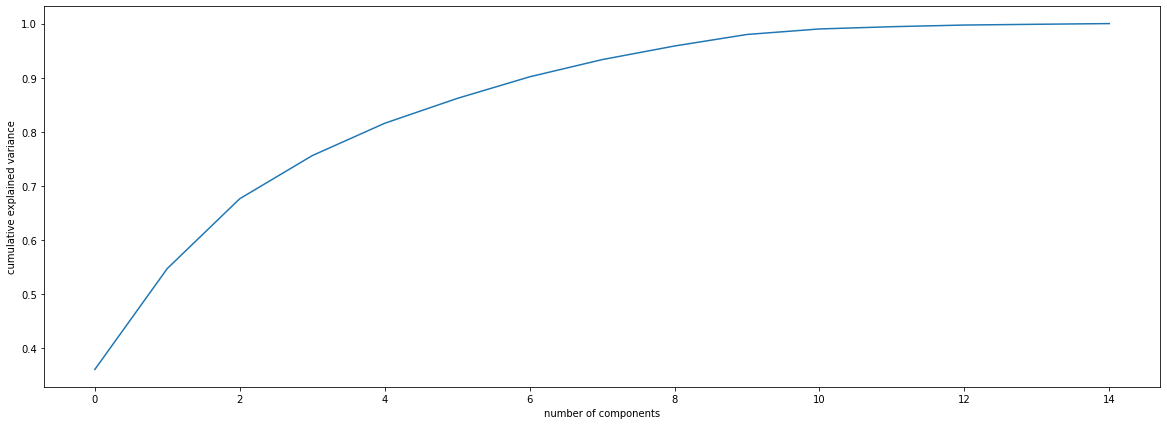

In [26]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Hence, we can apply PCA with our number of components needed.

In [67]:
n_components = 9
pca = PCA(n_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

Now for identifying the most important feature, we have to check which features are contributing most to the components.

In [68]:
pd.DataFrame(pca.components_, columns = df.columns)

n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df.columns
# get the most important feature names
most_important_names = list(set([initial_feature_names[most_important[i]] for i in range(n_pcs)]))
print(most_important_names)

['so2_station_3', 'Toluene_station_3', 'Benzene_station_3', 'no2_station_3', 'O-Xylene_station_3', 'no2_station_6', 'so2_station_6']


In [227]:
model_pca = model_VAR(df[most_important_names])
model_vanilla = model_VAR(df)

In [228]:
print(f'AIC with PCA: {model_pca.aic}; without PCA: {model_vanilla.aic}')

AIC with PCA: 6.926049270735869; without PCA: 17.218789488743795


### **GFSM**:  <a href="https://hal.archives-ouvertes.fr/hal-02448277/document">a Feature Selection Method for Improving Time Series Forecasting</a> 

GFSM is a feature selection investigated by some researches for MTS. 

The common measures like **correlation** and **Mutual Information**, are symmetric, so they do not provide enough information about the dependencies between variables, i.e., which variables influence the other. The main limitation of those approaches is that they potentially ignore hidden relationship between predictor variables. That is, the same hidden source of information may be exploited despite the fact of using with multiple selected variables. 

GFSM is a causality based method which takes into account the impact of one time series on an another one in terms of prediction. It is based on the **Granger causality**.

Let us consider two univariate time series *xt*, *yt*. The Granger definition of causality acknowledges the fact that *xt* causes *yt* if it contains information helpful to predict *yt*. In other words, *xt* causes *yt* if a prediction model that uses both *xt* and *yt* performs better than the one that is based merely on *yt*

We assume that causality is more important than correlation measures when forecasting time series. Because, in contrast to correlation, causality models the non-symmetric dependencies between variables.

The proposed method can be divided into four steps:

* Build the adjacency matrix of causalities between variables.
* Eliminate variables having low causality on the target.
* Cluster the set of the remaining predictors variables, by minimizing the causalities between clusters, and maximizing the causality within clusters.
* Choose one element from each cluster, the one that maximizes the causality on the target variable.

In [90]:
df, _ = stationary_dataframe(data["2020"].resample("2H").mean().iloc[:,:15], True)

Number of times dataframe got differed:  0


We compute the granger causation matrix for our dataframe and we make it symmetric by using the max aggregation function.

In [24]:
lagrange_matrix = grangers_causation_matrix(df, df.columns, test='ssr_ftest')
lgm = symmetrize(lagrange_matrix)
lgm_df = pd.DataFrame(lgm, columns=df.columns, index=df.columns)

To choose the optimal number of clusters, we can perform multiple clusterings and keep track of the inertia.

In [46]:
results = k_medoids(lgm, np.arange(2, lgm.shape[0]))

<AxesSubplot:>

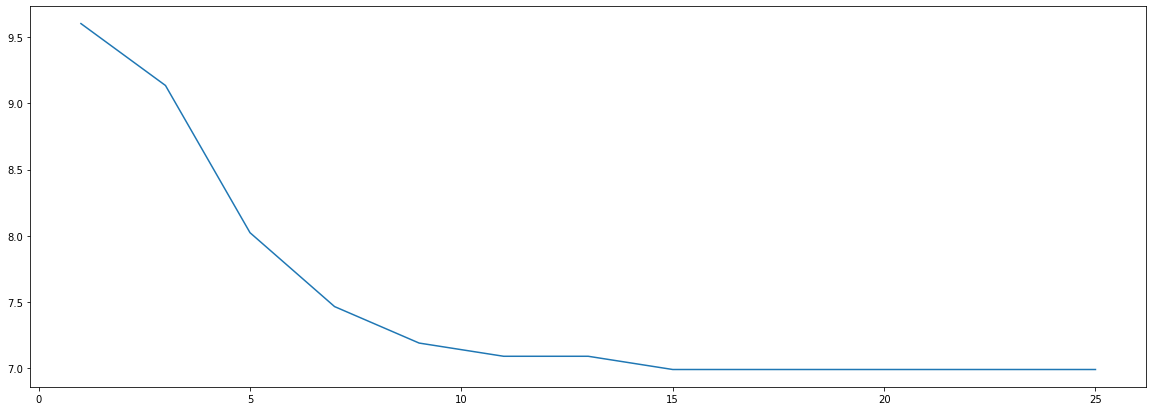

In [47]:
results[results["method"] == "pam"].inertia.plot()

We can now perform the clustering task using our Granger matrix with the number of clusters we want (i.e the number of features we want to keep after the feature selection process)

In [57]:
KMobj = KMedoids(n_clusters=9, metric="precomputed").fit(lgm)
km_labels = KMobj.labels_

We then save amongst each cluster the feature with the highest causality with our target

In [58]:
target = "no_station_3"
features = clustering_features(lgm_df, km_labels, target)
gfsm_df = df[features]

Now that we have our features selected, we can use a model to forecast and test it.

In [85]:
nobs = 186
df_forecast, rmse = model_forecast(gfsm_df, nobs, target)

***

## Feature Selection Module

To summarize all our studies, we have created a python module to encapsulate what we have been able to study. Its objective is to provide an interface for applying and visualizing feature selection methods specific to spatio-temporal data.

In [1]:
%%capture --no-stdout

# Import module
from src.FeatureSelection import FeatureSelection
import pandas as pd

# Import data sample
data = pd.read_csv('./data/sample.csv', index_col=0)

# Import stations references
stations_references = pd.read_csv("./data/liste-des-stations-rsqa.csv")

# Instanciation of FeatureSelection
fs = FeatureSelection()

# Registering the stations
fs.register_stations(
    stations_references[stations_references['statut'] == 'ouvert'], # Select open stations
    id_column="numero_station", # Indicate the unique id column name
    get_id_from_sensor_regex="station_([0-9]+)", # Indicate how to get this unique id from the data column's names
    lon_column='longitude', # Indicate longitude column
    lat_column='latitude', # Indicate latitude column
    name_column='nom' # Indicate name column
)

In [2]:
# Explore the stations
fs.explore_stations()

In [3]:
# Check available methods
fs.get_available_methods()

['PearsonCorrelation']

In [4]:
# Apply a feature selection method (PearsonCorrelation) to the data for the targets pm2_5_station_3 and no_station_3
fs.select(data, target_columns=['pm2_5_station_3', 'no_station_3'], method_names=['PearsonCorrelation'])

In [5]:
# Explore the results for the method PearsonCorrelation and the target pm2_5_station_3
fs.explore(used_target='pm2_5_station_3', used_method='PearsonCorrelation')

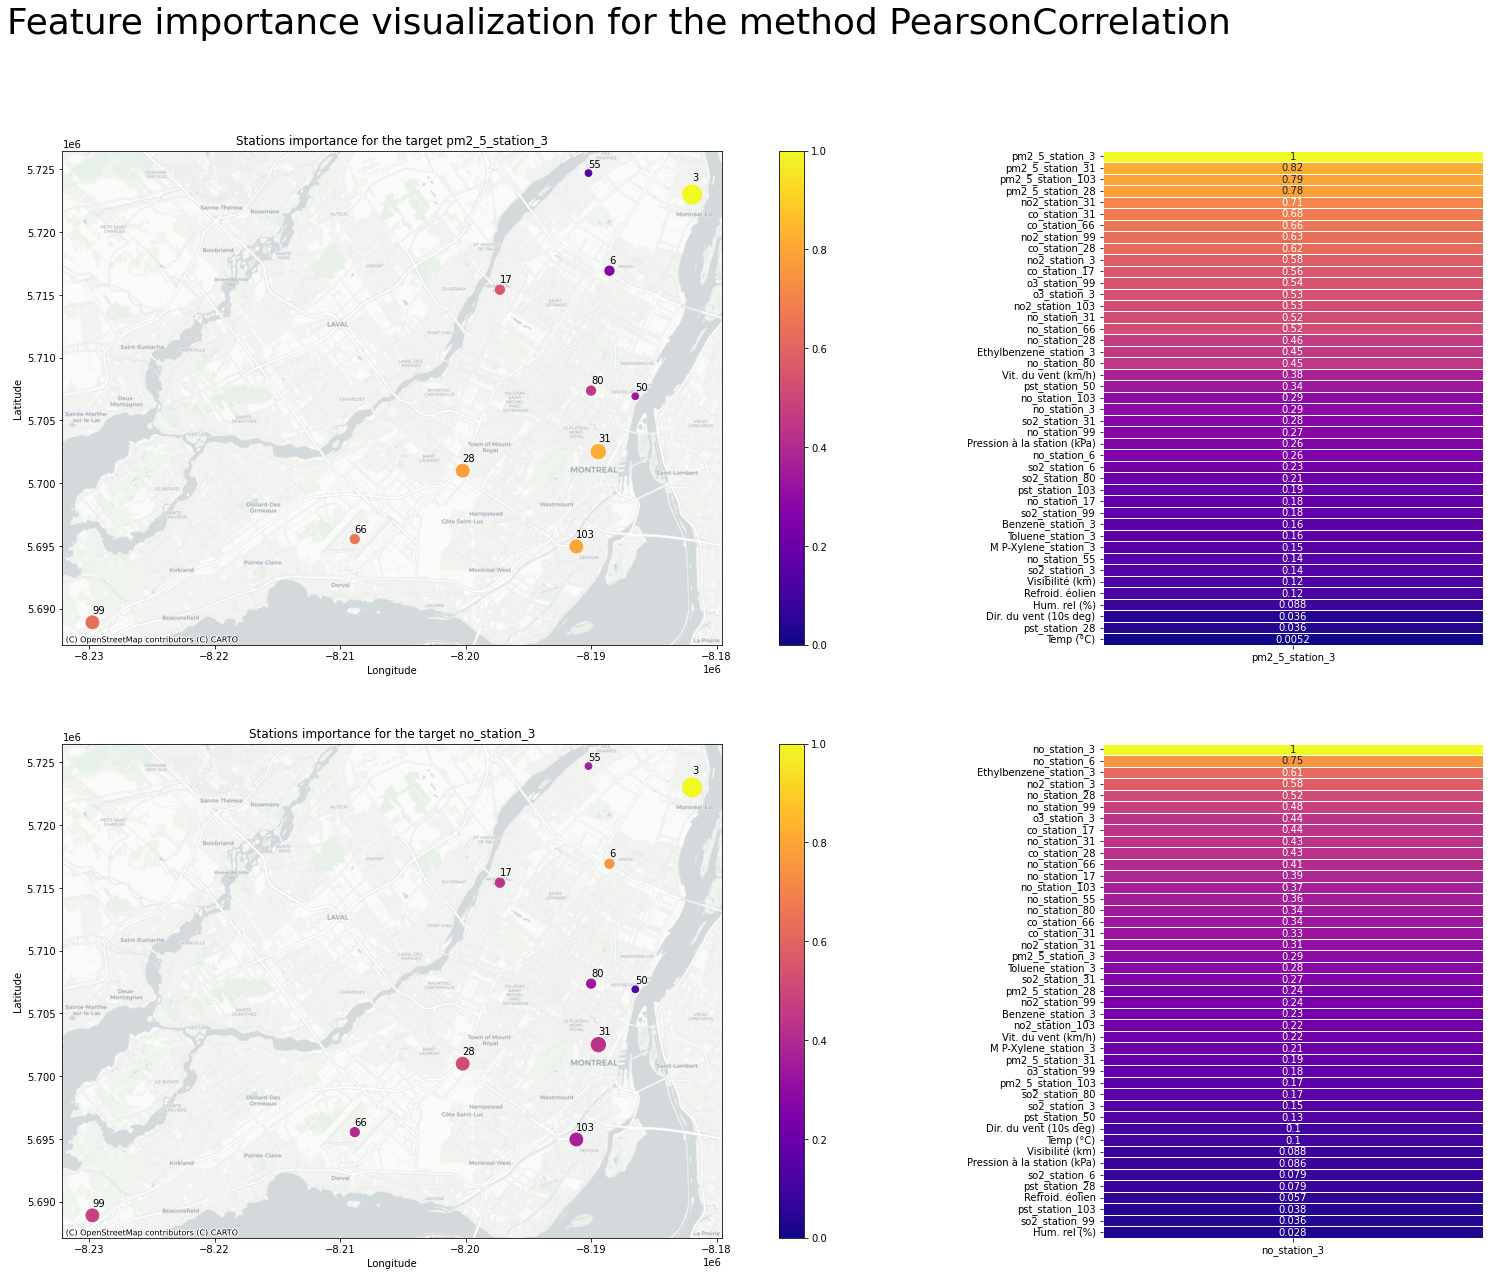

In [6]:
# Plot the results
fs.plot()

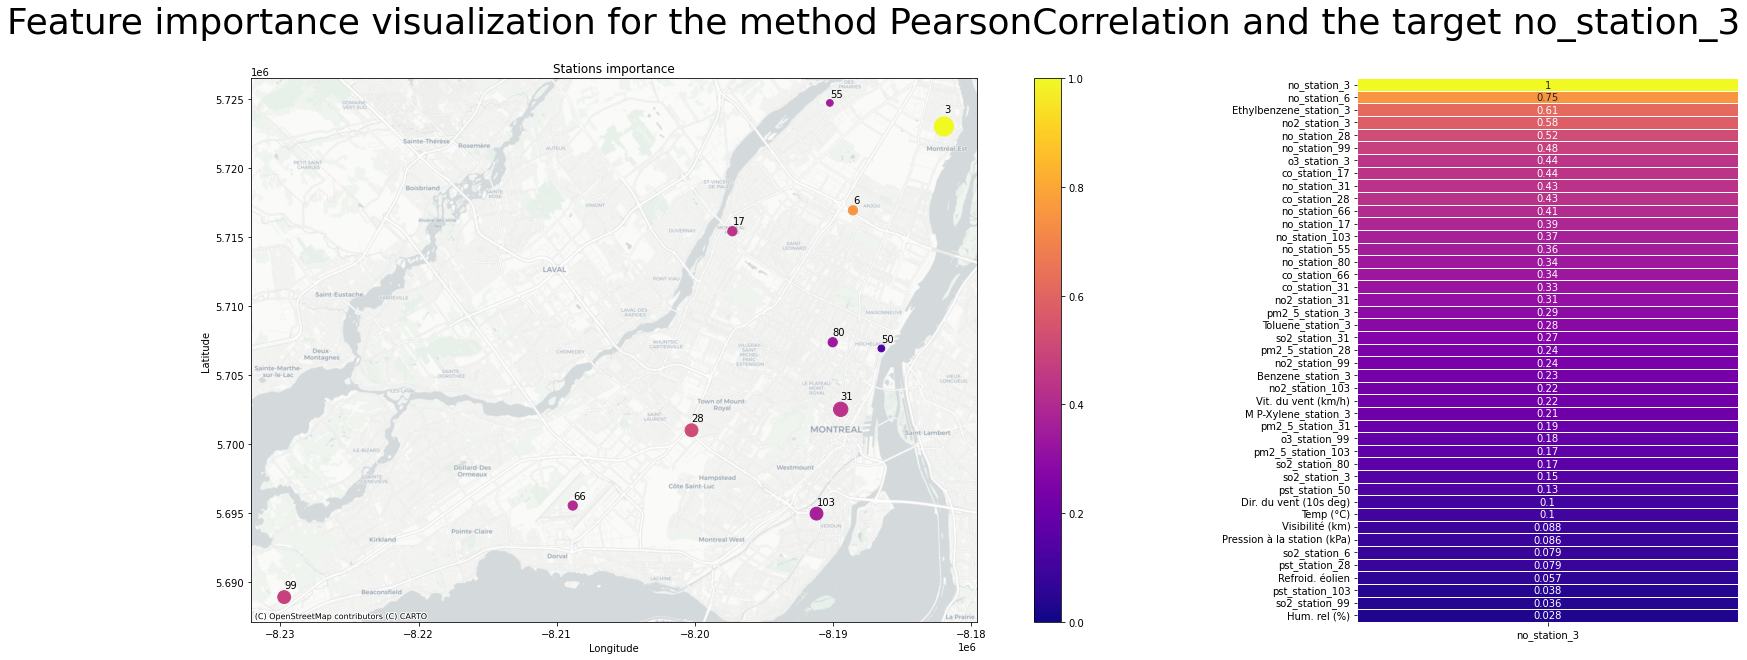

In [27]:
# Plot the results only for the target no_station_3
fs.plot(used_targets=['no_station_3'])

## References

* Shuchu Han, Alexandru Niculescu-Mizil. 1 May 2020. [Supervised Feature Subset Selection and Feature Ranking for Multivariate Time Series without Feature Extraction](https://doi.org/10.48550/arXiv.2005.00259)
* Bahavathy Kathirgamanathan, Padraig Cunningham. August 2020. [A Feature Selection Method for Multi-Dimension Time-Series Data](https://project.inria.fr/aaltd20/files/2020/08/AALTD_20_paper_Kathirgamanathan.pdf)
* Kiyoung Yang, Hyunjin Yoon, Cyrus Shahabi. May 2005. [CLeVer: A Feature Subset Selection Technique for Multivariate Time Series](https://www.researchgate.net/publication/225978198_CLeVer_A_Feature_Subset_Selection_Technique_for_Multivariate_Time_Series)
* Youssef Hmamouche, Alain Casali, Lotfi Lakhal. May 2017. [A Causality Based Feature Selection Approach for Multivariate Time Series Forecasting](https://hal.archives-ouvertes.fr/hal-01467523/document)
* Josu Ircio, Aizea Lojo, Usue Mori, and Jose A. Lozano. [Mutual Information Based Feature Subset Selection in Multivariate Time Series Classification](https://bird.bcamath.org/bitstream/handle/20.500.11824/1186/Manuscript.pdf;jsessionid=EA3EC758EA7E39529DA7D1FEF5C171E5?sequence=1)
* Bahavathy Kathirgamanathan, Pádraig Cunningham. 26 November 2021. [Correlation Based Feature Subset Selection for Multivariate Time-Series Data](https://arxiv.org/pdf/2112.03705.pdf)
* Kang Gu, Soroush Vosoughi, Temiloluwa Prioleau. 21 October 2021. [Feature Selection for Multivariate Time Series via Network Pruning](https://arxiv.org/pdf/2102.06024.pdf)
* Li Cao, Yanting Chen, Zhiyang Zhang, and Ning Gu. 21 July 2021. [A Multiattention-Based Supervised Feature Selection Method for Multivariate Time Series](https://doi.org/10.1155/2021/6911192)